In [7]:
# -*- coding: utf-8 -*-
"""
@author: Faron
"""
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from datetime import datetime

'''
This kernel implements the O(n²) F1-Score expectation maximization algorithm presented in
"Ye, N., Chai, K., Lee, W., and Chieu, H.  Optimizing F-measures: A Tale of Two Approaches. In ICML, 2012."

It solves argmax_(0 <= k <= n,[[None]]) E[F1(P,k,[[None]])]
with [[None]] being the indicator for predicting label "None"
given posteriors P = [p_1, p_2, ... , p_n], where p_1 > p_2 > ... > p_n
under label independence assumption by means of dynamic programming in O(n²).
'''


class F1Optimizer():
    def __init__(self):
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)


def print_best_prediction(P, pNone=None):
    print("Maximize F1-Expectation")
    print("=" * 23)
    P = np.sort(P)[::-1]
    n = P.shape[0]
    L = ['L{}'.format(i + 1) for i in range(n)]

    if pNone is None:
        print("Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)")
        pNone = (1.0 - P).prod()

    PL = ['p({}|x)={}'.format(l, p) for l, p in zip(L, P)]
    print("Posteriors: {} (n={})".format(PL, n))
    print("p(None|x)={}".format(pNone))

    opt = F1Optimizer.maximize_expectation(P, pNone)
    best_prediction = ['None'] if opt[1] else []
    best_prediction += (L[:opt[0]])
    f1_max = opt[2]

    print("Prediction {} yields best E[F1] of {}\n".format(best_prediction, f1_max))


def save_plot(P, filename='expected_f1.png'):
    E_F1 = pd.DataFrame(F1Optimizer.get_expectations(P).T, columns=["/w None", "/wo None"])
    best_k, _, max_f1 = F1Optimizer.maximize_expectation(P)

    plt.style.use('ggplot')
    plt.figure()
    E_F1.plot()
    plt.title('Expected F1-Score for \n {}'.format("P = [{}]".format(",".join(map(str, P)))), fontsize=12)
    plt.xlabel('k')
    plt.xticks(np.arange(0, len(P) + 1, 1.0))
    plt.ylabel('E[F1(P,k)]')
    plt.plot([best_k], [max_f1], 'o', color='#000000', markersize=4)
    plt.annotate('max E[F1(P,k)] = E[F1(P,{})] = {:.5f}'.format(best_k, max_f1), xy=(best_k, max_f1),
                 xytext=(best_k, max_f1 * 0.8), arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=7),
                 horizontalalignment='center', verticalalignment='top')
    plt.show()


def timeit(P):
    s = datetime.now()
    F1Optimizer.maximize_expectation(P)
    e = datetime.now()
    return (e-s).microseconds / 1E6


def benchmark(n=100, filename='runtimes.png'):
    results = pd.DataFrame(index=np.arange(1,n+1))
    results['runtimes'] = 0

    for i in range(1,n+1):
        runtimes = []
        for j in range(5):
            runtimes.append(timeit(np.sort(np.random.rand(i))[::-1]))
        results.iloc[i-1] = np.mean(runtimes)

    x = results.index
    y = results.runtimes
    results['quadratic fit'] = np.poly1d(np.polyfit(x, y, deg=2))(x)

    plt.style.use('ggplot')
    plt.figure()
    results.plot()
    plt.title('Expectation Maximization Runtimes', fontsize=12)
    plt.xlabel('n = |P|')
    plt.ylabel('time in seconds')
    plt.show()


Maximize F1-Expectation
Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)
Posteriors: ['p(L1|x)=0.3', 'p(L2|x)=0.2'] (n=2)
p(None|x)=0.5599999999999999
Prediction ['None', 'L1'] yields best E[F1] of 0.5633333333333332

Maximize F1-Expectation
Posteriors: ['p(L1|x)=0.3', 'p(L2|x)=0.2'] (n=2)
p(None|x)=0.57
Prediction ['None'] yields best E[F1] of 0.57

Maximize F1-Expectation
Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)
Posteriors: ['p(L1|x)=0.9', 'p(L2|x)=0.6'] (n=2)
p(None|x)=0.039999999999999994
Prediction ['L1', 'L2'] yields best E[F1] of 0.8200000000000001

Maximize F1-Expectation
Estimate p(None|x) as (1-p_1)*(1-p_2)*...*(1-p_n)
Posteriors: ['p(L1|x)=0.5', 'p(L2|x)=0.4', 'p(L3|x)=0.35', 'p(L4|x)=0.33', 'p(L5|x)=0.31', 'p(L6|x)=0.3', 'p(L7|x)=0.29', 'p(L8|x)=0.27', 'p(L9|x)=0.25', 'p(L10|x)=0.2', 'p(L11|x)=0.15', 'p(L12|x)=0.1'] (n=12)
p(None|x)=0.015012410773814995
Prediction ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9'] yields best E[F1] of 0.4636509302493286

Maxim

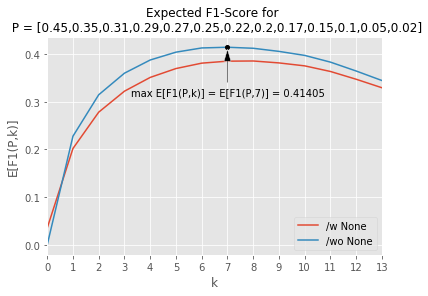

In [8]:
print_best_prediction([0.3, 0.2])
print_best_prediction([0.3, 0.2], 0.57)
print_best_prediction([0.9, 0.6])
print_best_prediction([0.5, 0.4, 0.3, 0.35, 0.33, 0.31, 0.29, 0.27, 0.25, 0.20, 0.15, 0.10])
print_best_prediction([0.5, 0.4, 0.3, 0.35, 0.33, 0.31, 0.29, 0.27, 0.25, 0.20, 0.15, 0.10], 0.2)

save_plot([0.45, 0.35, 0.31, 0.29, 0.27, 0.25, 0.22, 0.20, 0.17, 0.15, 0.10, 0.05, 0.02])
# benchmark()